In [468]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
import math
import re

In [2]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [4]:
import getpass
import requests

In [5]:
import datetime
from datetime import date
from datetime import timedelta

In [60]:
from textblob import TextBlob

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer

In [137]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [499]:
import ast
from time import sleep 

# API

### 1. NewsAPI connection

In [6]:
API_KEY=str(getpass.getpass('NewsAPI key?'))

NewsAPI key?········


### 2. Functions to run

In [7]:
def lower_tok_stop(text):
    
    stop_words = stopwords.words('english')
    
    lower_text = text.lower()
    tokens = word_tokenize(lower_text)
    clean_tokens = [word for word in tokens if word.isalpha()]
    remove_stop = [word for word in clean_tokens if not word in stop_words]
    return remove_stop

In [8]:
def TF_Naive_Bayes(dataNB):
    train = pd.read_csv('BBC_train.csv')
    test = pd.read_csv('BBC_test.csv')
    
    train_X = train['text_clean']   
    train_y = train['label']   
    data = dataNB['text_clean']
    #test_X = test['text_clean']
    #test_y = test['label']
    
    tf_vectorizer = CountVectorizer() # term frequency
    X_train_tf = tf_vectorizer.fit_transform(train_X)
    #debería meter aquí mi nuevo dataset
    #X_test_tf = tf_vectorizer.transform(test_X)
    X_data_tf = tf_vectorizer.transform(data)
    
    
    Naive_Bayes = MultinomialNB()
    Naive_Bayes.fit(X_train_tf, train_y)
    
    y_pred = Naive_Bayes.predict(X_data_tf)
    
    y_pred_cat = []
    
    for label in y_pred:
        if label == 0:
            y_pred_cat.append('business')    
        elif label == 1:
            y_pred_cat.append('entertainment')
        elif label == 2:
            y_pred_cat.append('politics')
        elif label == 3:
            y_pred_cat.append('sport')
        elif label == 4:
            y_pred_cat.append('tech')
    
    return y_pred_cat

In [9]:
def create_API_data_today_df():
    
    responses = []

    today = str(date.today())
    last_week = pd.date_range(end=today, periods=8)
    last_week_list = list(last_week.strftime("%Y-%m-%d"))


    for d in last_week_list:
        r = requests.get('https://newsapi.org/v2/everything?from='+d+'&to='+d+'&sources=bbc-news&pageSize=100&apiKey='+API_KEY)
        responses.append(r.json())
        
     
    #getting title, description and url fields --> 'article' will be a nested list with all the articles:
    
    article = []

    for day in responses:
        for ar in day['articles']:
            list_items = [ar['title'],ar['description'],ar['url']]
            article.extend([list_items])
    
            
    #create dataframe from article nested list:
    
    API_data = pd.DataFrame(article, columns=['title', 'description', 'url'])
        
    #create new column with cleaned text applying previously defined function lower_tok_stop
 
    API_data['text_clean'] = (API_data["title"] +'.'+ API_data["description"]).apply(lower_tok_stop)
    
    API_data.to_csv('API_data_today.csv', index = False)

    
    return
    

In [10]:
create_API_data_today_df()

In [70]:
def sentiment_analysis(text):
    textblob = TextBlob(text)
    sentiment = textblob.sentiment.polarity
    return sentiment

In [220]:
def convert_list_to_string(org_list, seperator=' '):
    return seperator.join(org_list)

In [55]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(20,15))
    plt.imshow(wordcloud)
    #no axis details
    plt.axis('off');

In [278]:
def create_word_cloud(text):
    
    stopwords_cloud = STOPWORDS
    more = ['two','three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'bbc', 'BBC', 'latest', 'news', 'minute', 'bulletin']
    stopwords_cloud.update(more)
    
    mask = np.array(Image.open('upvote.png'))
    wordcloud = WordCloud(width = 1500, height = 1000, random_state = 1, background_color = 'white', colormap = 'tab10', collocations = False, stopwords = stopwords_cloud, mask = mask).generate(text)
    
    # to save the image
    wordcloud.to_file('WordCloud_today.png')
    
    return plot_cloud(wordcloud)

## Good News Robot Dataframe

In [293]:
def Good_News_Robot_df():
    
    df = pd.read_csv('API_data_today.csv')
    
    dataNB = df.drop(columns=['title', 'description', 'url'])
    
    df['category'] = TF_Naive_Bayes(dataNB)
    df['sentiment'] = df['text_clean'].apply(lambda x: sentiment_analysis(x))
    
    df = df.sort_values(by=['sentiment'], ascending=False)
    
    df.to_csv('API_data_today_ML_Senti.csv', index = False)
    
    df_good_news = df[df['sentiment'] >= 0.5].reset_index(drop=True)
    
    return df_good_news

In [305]:
#Good_News_Robot_df()

- *Good News Robot Skills - WordCloud*

In [294]:
def Good_News_Robot_WordCloud():

    df_good_news = Good_News_Robot_df()
    df_good_news['text_cloud'] = df_good_news['text_clean'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: convert_list_to_string(x))
    
    text_cloud_all = ' '.join(df_good_news['text_cloud'].tolist())
    create_word_cloud(text_cloud_all)
      
    return 

- *Good News Robot Skills - Category break out*

In [492]:
def Good_Neutral_Bad_news_stack_bar():
    
    df = pd.read_csv('API_data_today_ML_Senti.csv')

    groups = df['category'].value_counts().sort_index()
    category = groups.index.tolist()
    category_freq = groups.tolist()

    positive_subset = df[df['sentiment'] >= 0.5].reset_index(drop=True)
    negative_subset = df[df['sentiment'] <= -0.5].reset_index(drop=True)
    neutral_subset = df[df['sentiment'].between(-0.5, 0.5, inclusive = False)].reset_index(drop=True)

    groups_positive = positive_subset['category'].value_counts().sort_index().tolist()
    groups_negative = negative_subset['category'].value_counts().sort_index().tolist()
    groups_neutral = neutral_subset['category'].value_counts().sort_index().tolist()

    positive_scores_count =  np.array(groups_positive)
    neutral_scores_count = np.array(groups_neutral)
    negative_scores_count = np.array(groups_negative)

    ind = np.arange(5)    
    width = 0.35       

    p1 = plt.bar(ind, negative_scores_count, width, color='blue', )
    p2 = plt.bar(ind, neutral_scores_count, width, color='palegreen', bottom=negative_scores_count)
    p3 = plt.bar(ind, positive_scores_count, width, color='orange', bottom = negative_scores_count+neutral_scores_count)

    plt.ylabel('Count')
    plt.title('Good News, Neutral and Bad News')
    plt.xticks(ind, category)
    plt.legend((p1[0], p2[0], p3[0]), ('Bad News', 'Neutral', 'Good News'))

    plt.show()
    
    return

# ----------------------------------------------------------------------------------------

### 2. API multiple request function: last week news data

- We will take the first 100 news of the last 8 days (eg. If tody is monday, we will take from last monday to current monday, both included)

In [ ]:
def NewsAPI_request_8days():
    
    responses = []
    
    today = str(date.today())
    last_week = pd.date_range(end=today, periods=8)
    last_week_list = list(last_week.strftime("%Y-%m-%d"))
    
    
    for d in last_week_list:
        r = requests.get('https://newsapi.org/v2/everything?from='+d+'&to='+d+'&sources=bbc-news&pageSize=100&apiKey='+API_KEY)
        responses.append(r.json())
                        
    return responses

In [ ]:
responses = []
    
today = str(date.today())
last_week = pd.date_range(end=today, periods=8)
last_week_list = list(last_week.strftime("%Y-%m-%d"))
    
    
for d in last_week_list:
    r = requests.get('https://newsapi.org/v2/everything?from='+d+'&to='+d+'&sources=bbc-news&pageSize=100&apiKey='+API_KEY)
    responses.append(r.json())

In [ ]:
responses

In [ ]:
len(responses)

In [ ]:
len(responses[7]['articles'])

In [ ]:
article = []
    
for day in responses:
    for ar in day['articles']:
        list_items = [ar['title'],ar['description'],ar['url']]
        article.extend([list_items])

In [ ]:
article

### 3. Storing relevant data from API into Dataframe

In [ ]:
def get_news_text(responses):
    
    article = []
    
    for day in responses:
        
        for ar in day['articles']:
            list_items = [ar['title'],ar['description'],ar['url']]
            article.extend([list_items])
    
    return article
    

In [ ]:
get_news_text(responses)

In [ ]:
nested_data = get_news_text(responses_8_days)

In [ ]:
NewsAPI_BBC_df = pd.DataFrame(nested_data, columns=['title', 'description', 'url'])

In [ ]:
NewsAPI_BBC_df.to_csv('BBC_df_8days_API_28_07_2021.csv', index=False)

In [ ]:
API_data = pd.read_csv('BBC_df_8days_API_28_07_2021.csv')

In [ ]:
API_data

### 4. Processing API Dataframe

 #### 4.1 Creating text column

In [ ]:
API_data['text_clean'] = (API_data["title"] +'.'+ API_data["description"]).apply(lower_tok_stop)

In [ ]:
API_data

In [ ]:
API_data['text_clean']

In [ ]:
data

In [ ]:
TF_Naive_Bayes(data)

#### 4.2 Removing unnecessary columns & applying lower_tok_stop

In [ ]:
API_data = API_data.drop(columns=['title', 'description', 'url'])

In [ ]:
API_data['text_clean'] = API_data['text'].apply(lower_tok_stop)

In [ ]:
API_data = API_data.drop(columns = 'text')

In [ ]:
API_data

In [ ]:
API_data.to_csv('API_data_cleaned.csv', index = False)

In [ ]:
df

# TF VECTORIZER

In [ ]:
train = pd.read_csv('BBC_news_train.csv')


In [ ]:
train.head()

# NEWS CATEGORIZATION

In [ ]:
df = pd.read_csv('bbc-news-data.csv', sep='\t')

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df = df.drop(columns=['filename'])

In [ ]:
df.isnull().sum()

### Creating text column: title + content

In [ ]:
df["text"] = df["title"] +'.'+ df["content"]

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

In [ ]:
duplicated_content = df[df.duplicated(subset=['content'], keep=False)]

In [ ]:
duplicated_content

- We have some news that are the same but have different headers. We keep them anyway

### Label encoding

In [ ]:
df['category'].unique()

- business: 0
- entertainment: 1
- politics: 2
- sport: 3
- tech: 4

In [ ]:
def label(category):
    if category == 'business':
        return 0
    elif category == 'entertainment':
        return 1
    elif category == 'politics':
        return 2
    elif category == 'sport':
        return 3
    elif category == 'tech':
        return 4
    else:
        return None

In [ ]:
df['label']=df['category'].apply(lambda x: label(x))

In [ ]:
df

In [ ]:
groups = df['category'].value_counts()

In [ ]:
groups

In [ ]:
ax = groups.plot(kind = 'bar', color=['gold', 'lightskyblue', 'palegreen', 'orange', 'pink'])

### Preprocessing

In order to make the model more efficient, let's clean the text

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
#stop_words = stopwords.words('english')

#### Lower the data, tokenize and remove stopwords

In [ ]:
#df['title'] = df['title'].apply(lambda x: x.lower())
#df['content'] = df['content'].apply(lambda x: x.lower())
#df['text'] = df['text'].apply(lambda x: x.lower())

In [ ]:
#def tokenize(text):
#    tokenized = word_tokenize(text)
#    return tokenized

In [ ]:
def lower_tok_stop(text):
    
    stop_words = stopwords.words('english')
    
    lower_text = text.lower()
    tokens = word_tokenize(lower_text)
    clean_tokens = [word for word in tokens if word.isalpha()]
    remove_stop = [word for word in clean_tokens if not word in stop_words]
    return remove_stop

In [ ]:
df['text_clean'] = df['text'].apply(lower_tok_stop)

In [ ]:
df

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df.to_csv('bbc-news-data-processed.csv')

## Maybe later increase stopwords!! also, us...

## Feature engineering: TF-IDF

TF-IDF (Term Frequency Inverse Document Frequency) is an algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction

TfidfVectorizer - Transforms text to feature vectors that can be used as input to estimator

https://iq.opengenus.org/naive-bayes-on-tf-idf-vectorized-matrix/

- tf: Term Frequency = count(t, d) i.e., count of term t in document d.
- idf: inverse document frequency function --> idf ( t, d ) = log ( D / { d ∈ D : t ∈ d })


- t is the term/ word
- d is the document
- D is the total number of documents
- { d ∈ D : t ∈ d } denotes the number of documents in which t occur

- **tf-idf = tf * idf**

## Split train and test datases: 70/30

The dataset is sorted alphabetically by category! I will inercalate them using label

In [ ]:
df.groupby('label').cumcount()

In [ ]:
df['label_cumcounts'] = df.groupby('label').cumcount()

df=df.sort_values(['label_cumcounts', 'label'])
df=df.drop(columns=['label_cumcounts'])

In [ ]:
df.tail(10)

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.tail(10)

In [ ]:
df_train = df.tail(round(len(df['category'])*0.7)).reset_index(drop=True)

In [ ]:
df_test = df.head(round(len(df['category'])*0.3)).reset_index(drop=True)

In [ ]:
df_train.shape

In [ ]:
df_test.shape

In [ ]:
#df_train.to_csv('BBC_news_train.csv', index=False)
#df_test.to_csv('BBC_news_test.csv', index=False)

- Once I created train and test csv's, I comment the code so that they are not overwritten, as they were created using a function that randomizes the sorting

In [ ]:
df_train['category'].hist()

In [ ]:
df_test['category'].hist()

# TF VECTORIZER MODEL

In [ ]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [ ]:
train = pd.read_csv('BBC_train.csv')
test = pd.read_csv('BBC_test.csv')

In [ ]:
train_X = train['text_clean']   
train_y = train['label']   
test_X = test['text_clean']
test_y = test['label']

In [ ]:
#train.to_csv('BBC_train.csv', index=False)
#test.to_csv('BBC_test.csv', index=False)

## Applying tf vectorizer (count vectorizer)

- to extract features from training data

In [ ]:
tf_vectorizer = CountVectorizer() # term frequency

X_train_tf = tf_vectorizer.fit_transform(train_X)

print("n_samples: %d, n_features: %d" % X_train_tf.shape)

##  Transforming test data into tf-vectorized matrix

- to extract features from test data

In [ ]:
X_test_tf = tf_vectorizer.transform(test_X)

print("n_samples: %d, n_features: %d" % X_test_tf.shape)

# Naive Bayes

In [ ]:
t = time()

Naive_Bayes = MultinomialNB()
Naive_Bayes.fit(X_train_tf, train_y)

training_time = time() - t
print("train time: %0.3fs" % training_time)

### Calculating accuracy and generating classification report from test data

In [ ]:
# predict the new document from the testing dataset
t = time()
y_pred = Naive_Bayes.predict(X_test_tf)

test_time = time() - t
print("test time:  %0.3fs" % test_time)

# compute the performance measures
score1 = metrics.accuracy_score(test_y, y_pred)
print("accuracy:   %0.3f" % score1)

print(metrics.classification_report(test_y, y_pred, target_names=['0','1', '2', '3', '4']))

print("confusion matrix:")
print(metrics.confusion_matrix(test_y, y_pred))

print('------------------------------')

In [ ]:
len(y_pred)

# TF / Naive-Bayes function to predict

In [ ]:
dataNB

In [ ]:
def TF_Naive_Bayes(dataNB):
    train = pd.read_csv('BBC_train.csv')
    test = pd.read_csv('BBC_test.csv')
    
    train_X = train['text_clean']   
    train_y = train['label']   
    data = dataNB['text_clean']
    #test_X = test['text_clean']
    #test_y = test['label']
    
    tf_vectorizer = CountVectorizer() # term frequency
    X_train_tf = tf_vectorizer.fit_transform(train_X)
    #debería meter aquí mi nuevo dataset
    #X_test_tf = tf_vectorizer.transform(test_X)
    X_data_tf = tf_vectorizer.transform(data)
    
    
    Naive_Bayes = MultinomialNB()
    Naive_Bayes.fit(X_train_tf, train_y)
    
    y_pred = Naive_Bayes.predict(X_data_tf)
    
    y_pred_cat = []
    
    for label in y_pred:
        if label == 0:
            y_pred_cat.append('business')    
        elif label == 1:
            y_pred_cat.append('entertainment')
        elif label == 2:
            y_pred_cat.append('politics')
        elif label == 3:
            y_pred_cat.append('sport')
        elif label == 4:
            y_pred_cat.append('tech')
    
    return y_pred_cat
    

In [ ]:
TF_Naive_Bayes(dataNB)

In [ ]:
category_predicted_list = TF_Naive_Bayes(data)

In [ ]:
category_predicted_list

In [ ]:
data

## APPLYING NAIVE BAYES TO API DATA

In [ ]:
data = pd.read_csv('API_data_cleaned.csv')

In [ ]:
data.head()

In [ ]:
category = TF_Naive_Bayes(data)

In [ ]:
len(category)

In [ ]:
category_df=pd.DataFrame(category)

In [ ]:
All = pd.read_csv('BBC_df_8days_API_28_07_2021.csv')

In [ ]:
All

In [ ]:
All['category'] = category_df

- business: 0
- entertainment: 1
- politics: 2
- sport: 3
- tech: 4

# -------------------------------------------------------------------------------------

In [516]:
def GOOD_NEWS_ROBOT():
    print('Hi human! I am the GOOD NEWS Robot. I am here to inform you about the latest GOOD NEWS!')
    print('\n')
    print('First of all, let me show you ALL THE NEWS I gathered from the last 7 days broken down by category,')
    print('so you can see which categories have more GOOD NEWS!')

    for i in range(5):
        sleep(1)
          
    Good_Neutral_Bad_news_stack_bar()
    
    print('WOW not so bad! There are many neutral news, but we still have a lot of GOOD NEWS to stay happy!')
    print('But... what are these GOOD NEWS about? Let me show you :D')
    
    Good_News_Robot_WordCloud()
    
    print('I HOPE YOU ENJOY YOUR DAY!')
    

# -----------------------------    GOOD NEWS ROBOT   --------------------------------

<img src="Good_News_Robot_wallpaper.png" width="800"> 

Hi human! I am the GOOD NEWS Robot. I am here to inform you about the latest GOOD NEWS!


First of all, let me show you ALL THE NEWS I gathered from the last 7 days broken down by category,
so you can see which categories have more GOOD NEWS!


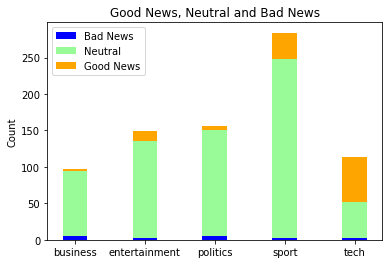

WOW not so bad! There are many neutral news, but we still have a lot of GOOD NEWS to stay happy!
But... what are these GOOD NEWS about? Let me show you :D
I HOPE YOU ENJOY YOUR DAY!


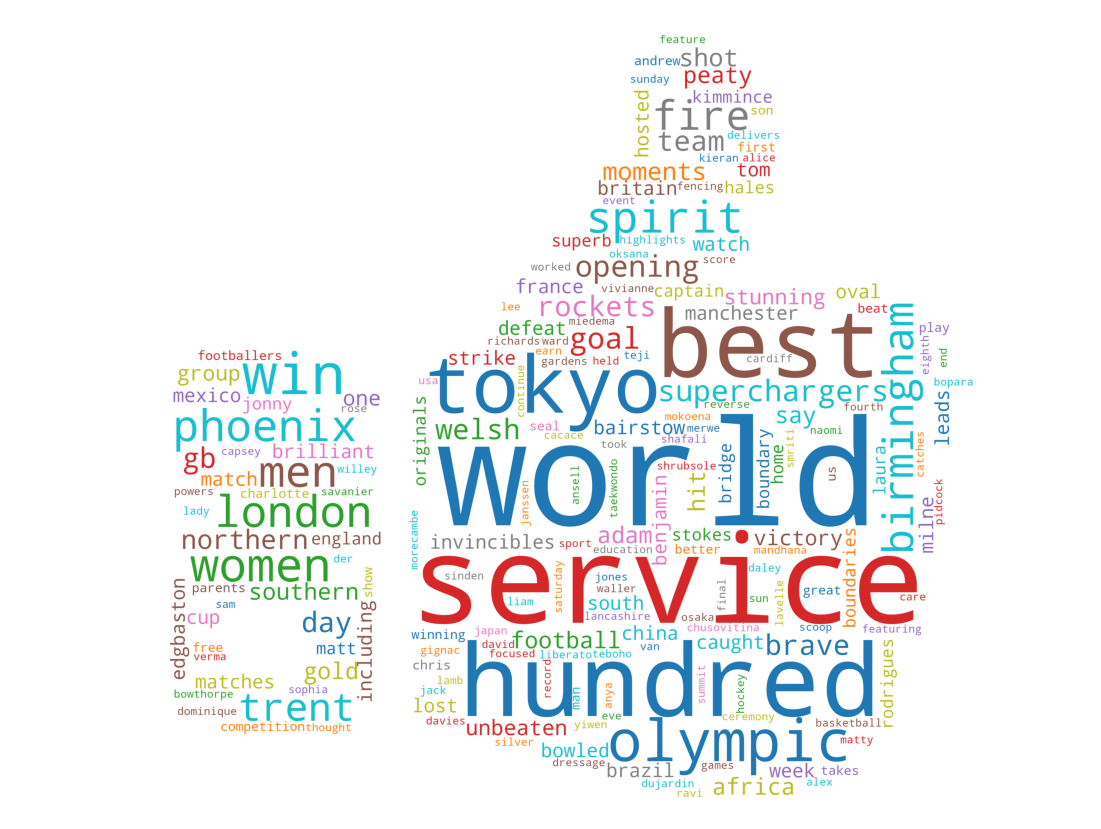

In [517]:
GOOD_NEWS_ROBOT()